In [1]:
#Till now we have implemented Multi-Layer perceptron, character level prediction
#we will feed 3 previous character and predict the 4th char in sequence
#we used 1 hidden layer and tanh non-linearities

In [61]:
#now, we will complexify this architecture
#we will take more input sequence as an input, and 
#more deeper model that progressively fuses the given information to make its guesses
#something similar to Wavenet# https://arxiv.org/abs/1609.03499

In [62]:
#Wavenet originaly converts speech sequences, but we will stick to characters
#wavenet is auto regressive model and tries to predict next char in a sequence 
#architecture actually takes intetesting hierarchial approach to predict next character in a sequence

In [63]:
#Taking codes from previous notebooks

In [64]:
from IPython.display import Image
from IPython.display import display

In [65]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [67]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [68]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [69]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [70]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [71]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [72]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [73]:
torch.manual_seed(42); # seed rng for reproducibility

In [74]:
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #no of neurons in the hidden layer of MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 #last layer makes less confident
    
parameters = [C] + [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
print(sum(p.nelement() for p in parameters)) #no of parameter in total
for p in parameters:
    p.requires_grad = True

12097


In [75]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), )
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7087
 120000/ 200000: 2.3243
 130000/ 200000: 2.2512
 140000/ 200000: 2.0113
 150000/ 200000: 1.8195
 160000/ 200000: 1.7985
 170000/ 200000: 2.2206
 180000/ 200000: 2.0566
 190000/ 200000: 2.1030


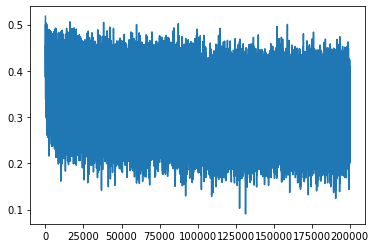

In [76]:
plt.plot(lossi)

In [77]:
#put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [78]:
#evaluate the loss
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())
    
#put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.0621414184570312
val 2.109346389770508


In [79]:
# sample from the model
for _ in range(20): 
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the contect window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix==0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

damiara.
alyzah.
faraliza.
francy.
roy.
lorie.
rossot.
emon.
catine.
aub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.


In [80]:
#Till now we have copied the code from previous notebooks and we know model has scope for improvements

In [81]:
#Let's get started....

In [82]:
#Lets fix the lossi plot, which is very tidy
#we know lossi is list of floats
lossi[:10]

[0.5180676579475403,
 0.5164594054222107,
 0.507362961769104,
 0.507546603679657,
 0.4992470443248749,
 0.5014019012451172,
 0.5049523115158081,
 0.48866209387779236,
 0.4999050199985504,
 0.4899313449859619]

In [83]:
#we need to average out these values to get more representative value along the way
#in pytorch, we create a range, it is one dimensions
#example
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [84]:
#but we can view this array into matrix using view funtion
torch.arange(10).view(2 , 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [85]:
#now we have converted into 2 D array
#we can also mention -1, pytorch will inbuilt calculate what to substitute there
#example
torch.arange(10).view(-1, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [86]:
torch.arange(10).view(-1, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [87]:
#this is helpful
#with this we can convert lossi values
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

In [88]:
#we converted as each row of 1000 values
#now we can do mean, along the rows, which can be plotted
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

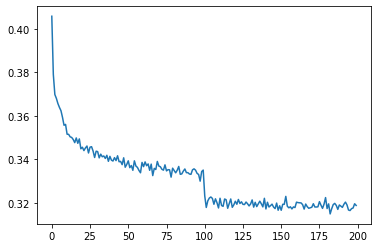

In [89]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [90]:
#notice the lossi graph is much better than previous version

In [91]:
#next, notice forward pass code is too many codes
#we organized some of these layers inside the layers list but not all of them
#we have embedding layer C - outside the layers list & view operation is also outside layers list
#lets create modules for both of these operations i.e embedding & flattening operation

In [92]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
  
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


In [93]:
#now we have these 2 classes
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #no of neurons in the hidden layer of MLP

#C = torch.randn((vocab_size, n_embd)) #moved inside layers list
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1 #last layer makes less confident
    
#parameters = [C] + [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
parameters = [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
print(sum(p.nelement() for p in parameters)) #no of parameter in total
for p in parameters:
    p.requires_grad = True

12097


In [94]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), )
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    #emb = C[Xb] #embed the characters into vectors
    #x = emb.view(emb.shape[0], -1) #concatenate the vectors
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3196


In [95]:
#notice we simplified the code

In [96]:
#pytorch has containers, which contains multiple layers
#lets implement in our code

In [97]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
  
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------------------

class Sequential:
    def __init__(self, layers): #we pass list of layers
        self.layers = layers #and keep the layers here
  
    def __call__(self, x): #given any input 
        for layer in self.layers: #we will call all the layers sequentially and return the result
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [98]:
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #no of neurons in the hidden layer of MLP

#C = torch.randn((vocab_size, n_embd)) #moved inside layers list
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]) #notice we used sequntial layer

with torch.no_grad():
    layers[-1].weight *= 0.1 #last layer makes less confident
    
#parameters = [C] + [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
#parameters = [p for layer in layers for p in layer.parameters()] #embedding + all layer parameters
parameters = model.parameters() #since we calculate this inside sequential class
print(sum(p.nelement() for p in parameters)) #no of parameter in total
for p in parameters:
    p.requires_grad = True

12097


In [99]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), )
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward Pass
    
    #emb = C[Xb] #embed the characters into vectors
    #x = emb.view(emb.shape[0], -1) #concatenate the vectors
    #x = Xb
    #for layer in layers:
    #    x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2172


In [100]:
#notice how forward pass layer creation is reduced simply using model function

In [101]:
for layer in model.layers: #we now have layers inside model function
    layer.training = False

In [102]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    #emb = C[x] #(N, block_size, n_embd)
    #x = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    #for layer in layers:
    #    x = layer(x)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
#put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 3.410376787185669
val 3.409686326980591


In [103]:
# sample from the model
for _ in range(20): 
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
        #emb = C[torch.tensor([context])] # (1,block_size,d)      
        #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        #for layer in layers:
        #    x = layer(x)
        #logits = x
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the contect window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix==0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

ewdfatceqvehczsqnduxgvguzevsultxiyggeutbhkotmjebjclcigpbbwzisqvjcjajebenhzk.
qehz.
hydpi.
bprslnja.
sopyfgswchiutjsbdvtbenenceunouydiwaofswhgbfxktqhhfwequljtjybenznevpnbypofppbzfcttnxzrulgwbnitqtvlkjism.
xntrpoxxfxyadtxis.
qilebhzcomvmwersbhpzrtqhvvbvgllulhyhx.
pedqngvmyexuxmfgnanpzskcxvabegnlhlpyqkiwthiftr.
yjdjhlhfhkonwirabkbkdcujlzs.
dxkaec.
hazanrbdvejenrqvgbbhjidgqwkji.
fjqynrsqtv.
khschyhlvkal.
vivkmvsbijtrrbzzlpddgdjljizk.
jilxmevgshvrrsotiqdngtzonklf.
fysrjstz.
og.
jxcvwudsghhnfbcpevperxzobiumfbrmla.
jirbojijqfslzbuenafululydwwjwfnxrjxwcrj.
jjkfrkg.


In [104]:
#notice we simplified the code here also
#output is bad, because we not yet trained

In [105]:
#now we can scale the neural network and make everything bigger and deeper

In [106]:
#we can make deeper, using sequntial layers
#but making bigger is tough 
#hence we leverage the concept mentioned in wavenet as shown below

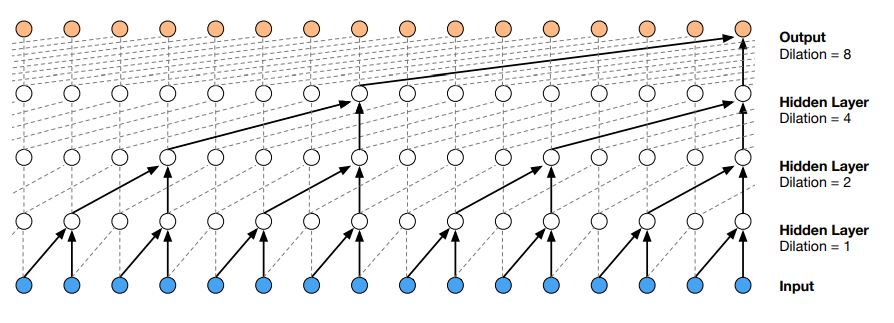

In [107]:
x = Image(filename=r"C:\Users\welcome\Desktop\AndrejKarpathy\wave.JPG")
display(x)

In [108]:
#we take 2 characters and fuse them into a sort of bi-gram representation
#we do that for all characters consecutively
#and then we fust into 4 character level chunks and then into 8 etc... like tree-like hierarchial manner
#"Dilated Causal Convolution Layers"

In [109]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])
